In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
data_dir= '/content/drive/MyDrive/Colab Notebooks/data'

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}


In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in dataloaders[phase]:
                inputs = inputs
                labels = labels

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False


num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)



criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [8]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8360 Acc: 0.5000
val Loss: 0.6938 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.7948 Acc: 0.4333
val Loss: 0.5886 Acc: 0.7000

Epoch 2/24
----------
train Loss: 0.5624 Acc: 0.7667
val Loss: 0.4912 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.5755 Acc: 0.6333
val Loss: 0.4860 Acc: 0.8000

Epoch 4/24
----------
train Loss: 0.5338 Acc: 0.7000
val Loss: 0.4755 Acc: 0.8000

Epoch 5/24
----------
train Loss: 0.3112 Acc: 0.9333
val Loss: 0.4380 Acc: 0.9000

Epoch 6/24
----------
train Loss: 0.5600 Acc: 0.6333
val Loss: 0.4302 Acc: 0.8000

Epoch 7/24
----------
train Loss: 0.3425 Acc: 0.8667
val Loss: 0.5038 Acc: 0.8000

Epoch 8/24
----------
train Loss: 0.3390 Acc: 0.8333
val Loss: 0.5036 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.2195 Acc: 1.0000
val Loss: 0.5130 Acc: 0.9000

Epoch 10/24
----------
train Loss: 0.3238 Acc: 0.8667
val Loss: 0.5018 Acc: 0.8000

Epoch 11/24
----------
train Loss: 0.1984 Acc: 0.9333
val Loss: 0.5729 Acc: 0.8000

Ep

In [10]:
class Custom(Dataset):
    def __init__(self,img_dir,transform=None):
        super(Custom,self).__init__()
        self.transform=transform
        self.img_dir=img_dir
        self.images=os.listdir(img_dir)
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path=os.path.join(self.img_dir,self.images[index])
        image=np.array(Image.open(image_path))
        if self.transform:
            image=self.transform(image)
            
        return image

In [11]:
struck_test_transforms=transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((256,256)),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

['normal', 'struck']


In [13]:
cd '/content/drive/MyDrive/Colab Notebooks/word_segmentation/segmented'

/content/drive/MyDrive/Colab Notebooks/word_segmentation/segmented


In [14]:
ls

segment0.png   segment28.png  segment46.png  segment64.png  segment82.png
segment10.png  segment29.png  segment47.png  segment65.png  segment83.png
segment11.png  segment2.png   segment48.png  segment66.png  segment84.png
segment12.png  segment30.png  segment49.png  segment67.png  segment85.png
segment13.png  segment31.png  segment4.png   segment68.png  segment86.png
segment14.png  segment32.png  segment50.png  segment69.png  segment87.png
segment15.png  segment33.png  segment51.png  segment6.png   segment88.png
segment16.png  segment34.png  segment52.png  segment70.png  segment89.png
segment17.png  segment35.png  segment53.png  segment71.png  segment8.png
segment18.png  segment36.png  segment54.png  segment72.png  segment90.png
segment19.png  segment37.png  segment55.png  segment73.png  segment91.png
segment1.png   segment38.png  segment56.png  segment74.png  segment92.png
segment20.png  segment39.png  segment57.png  segment75.png  segment93.png
segment21.png  segment3.png   segment58

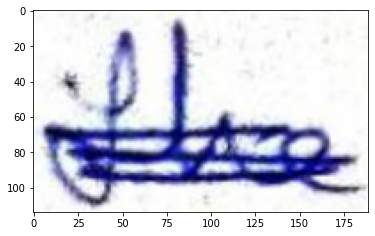

In [15]:
import matplotlib.image as img
  
# reading png image file
im = img.imread('segment0.png')
  
# show image
plt.imshow(im)

In [16]:
rm .DS_Store

rm: cannot remove '.DS_Store': No such file or directory


In [17]:
struck_ds=Custom('/content/drive/MyDrive/Colab Notebooks/word_segmentation/segmented',struck_test_transforms)

In [18]:
struck_loader=DataLoader(struck_ds,batch_size=16,shuffle=True)

In [19]:
import matplotlib.pyplot as plt

In [20]:
def img_show(img):
  img=img/2+0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [21]:
for index,imgs in enumerate(struck_loader):
  outputs=model_conv(imgs)
  _,preds=torch.max(outputs,1)
  

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for 

tensor([[[0.9922, 1.0000, 0.9686],
         [0.9922, 1.0000, 0.9636],
         [0.9922, 0.9969, 0.9639],
         ...,
         [0.9796, 0.9922, 0.9356],
         [0.9708, 0.9865, 0.9209],
         [0.9608, 0.9765, 0.9059]],

        [[0.9922, 1.0000, 0.9686],
         [0.9922, 1.0000, 0.9636],
         [0.9922, 0.9969, 0.9639],
         ...,
         [0.9796, 0.9922, 0.9356],
         [0.9708, 0.9865, 0.9209],
         [0.9608, 0.9765, 0.9059]],

        [[0.9922, 1.0000, 0.9686],
         [0.9922, 1.0000, 0.9636],
         [0.9922, 0.9969, 0.9639],
         ...,
         [0.9796, 0.9922, 0.9356],
         [0.9708, 0.9865, 0.9209],
         [0.9608, 0.9765, 0.9059]],

        ...,

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         ...,
         [0.9843, 0.9843, 0.9686],
         [0.9815, 0.9815, 0.9572],
         [0.9765, 0.9765, 0.9373]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.